In [52]:
import torch
import numpy as np
import os
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
# The simulation of the system: 3000 time steps.

V_th = 1 + 0.001 # threshold od spiking neurons
V_th_I = 1
V_reset = 0

def go(y, y0): # update function of the history of spikes / attention
    y[:-1, :] = y[1:, :]
    y[-1, :] = y0
    return y

def RF(delta, g, tau_r): # RF function, equation 14,20 in SI
    g_tmp = np.where(delta<tau_r,g,0)
    g_tmp = np.where(delta==0,1,g_tmp)
    return g_tmp


def simulation(x, DAE1, DAE2, lambda1,lambda2, r1,r2, tau_delta1, tau_delta2, g, tau_r1, tau_r2, tau_1, tau_2, tau_b, tau_t,
              tau_d, decay_rate=0.8, T=3000):
    # parameters are named according to the equations in SI, See table.2 in SI

    W = x.shape[0] # height of the image
    H = x.shape[1] # width of the image
    N = W * H
    d_spk1 = np.zeros((tau_d, N)) # the history of part-level spikes
    d_spk2 = np.zeros((tau_d, N)) # the history of whole-level spikes
    d_top = np.zeros((tau_d, N)) # the history of whole-level spikes, that is needed to compute the top-down feedback

    # initialization of top-down feedback
    gamma1 = np.random.rand(tau_d, N)
    gamma1 = gamma1 / gamma1.sum(0)
    gamma2 = np.random.rand(tau_d, N)
    gamma2 = gamma2/gamma2.sum(0)

    # initialization of delta
    delta1 = np.zeros(N)
    delta2 = np.zeros(N)

    # for ploting: spike recording and attention map
    spk1_record = []
    spk2_record = []
    ga1_record = []
    ga2_record = []
    Ga_record = []

    # for animation
    animation_record = []

    # driving input (original image)
    driv1 = x.reshape(N)
    for t in range(T): # total simulation period
        noise1 = np.random.rand(N) # for realizing bernoulli sampling based on firing rate firing rate
        eps1 = np.random.rand(N) # stochasticity at initial phase(part-level)
        eps2 = np.random.rand(N) # stochasticity at initial phase(whole-level)
        if t % tau_d == 0:          # rapid decay of the stochasticity at initial phase
            r1 = r1 * decay_rate
            r2 = r2 * decay_rate




        # ------------------------------------First block: computing part-level processes------------------------------------------------------------



        
        feedback = (gamma1[0]) * (d_top[:tau_t, :].sum(0)) + r1 * eps1 # equation 11,22 in SI

        ga_tmp1 = gamma1[0].copy() # to record feedback attention map (inner level)
        Ga_tmp = d_top[:tau_t, :].sum(0) # to record feedback attention map (inter level)

        rf1=RF(delta1, g, tau_r1) # computing the excitability based on the refractory variable delta : equation 14 in SI
        V1 = driv1 * (feedback) * rf1+ noise1 # membrane potential for bernoulli sampling: equation 12 in SI

        spk1 = np.where(V1 > V_th, 1, 0)
        delta1 = delta1- 1 + tau_delta1 * spk1
        delta1 = np.where(delta1 > 0, delta1, 0) # update of spike variable and refractory variable.

        d_spk1 = go(d_spk1, spk1) # update the history of spike pattern (of length tau_d)

        tensor_dspk1 = torch.tensor(d_spk1[-tau_1:, :].sum(0), dtype=torch.float32, device=device) # coincidence detector, integrate the spikes within time window tau_1
                                                                                                   # euqation 16 in SI
        gamma1_now = DAE1(tensor_dspk1).detach().cpu().numpy() # feed to DAE_1 and get the output  # equation 15 in SI
        gamma1 = go(gamma1, gamma1_now)                        # update the history of inner-level top-down attention gamma (of length tau_d)



        # ------------------------------------Second block: computing whole-level processes -----------------------------------------------------------------------------------------------------------------------




        driv2 = lambda1*d_spk1[-tau_b:, :].sum(0) + lambda2* driv1 # the drive of whole level: linear sum of input image and part-level spikes: (first term of) equation 17 in SI
        noise2 = np.random.rand(N) # for realizing bernoulli sampling based on firing rate

        rf2 = RF(delta2, g, tau_r2) # computing the excitability based on the refractory variable delta : equation 20 in SI
        V2 = driv2 * (gamma2[0]+r2*eps2) * rf2 + noise2 # membrane potential for bernoulli sampling: equation 17, 18 in SI
        ga_tmp2 = (gamma2[0]).copy() # record the inner-level top-down attention of whole level

        spk2 = np.where(V2 > V_th, 1, 0)
        delta2 = delta2 - 1 + tau_delta2 * spk2
        delta2 = np.where(delta2 > 0, delta2, 0)  # update of spike variable and refractory variable.

        d_spk2 = go(d_spk2, spk2) # update the history of spike pattern (of length tau_d)
        d_top = go(d_top, d_spk2[-1, :]) # update the relavant spikes to compute (inter level) top-down

        tensor_dspk2 = torch.tensor(d_spk2[-tau_2:, :].sum(0), dtype=torch.float32, device=device) # coincidence detector, integrate the spikes within time window tau_2
                                                                                                   # euqation 16 in SI
        gamma2_now = DAE2(tensor_dspk2).detach().cpu().numpy() # feed to DAE_2 and get the output  # equation 21 in SI
        gamma2 = go(gamma2, gamma2_now) # update the history of inner-level top-down attention gamma2 (of length tau_d)

        #------------------------------------Record some important values for ploting and animation-------------------------------------------------------------------------

        spk1_record.append(spk1)
        spk2_record.append(spk2)
        ga1_record.append(ga_tmp1)
        ga2_record.append(ga_tmp2)
        Ga_record.append(Ga_tmp)

        
        # record for animation
        animation_record.append(
            [spk1.reshape(W, H), (delta1 / tau_delta1).reshape(W, H), 
             ga_tmp1.reshape(W, H), d_spk1[-tau_1:, :].sum(0).reshape(W, H),
             driv1.reshape(W, H), lambda2*driv1.reshape(W, H), lambda1*driv2.reshape(W, H),
             Ga_tmp.reshape(W, H),
             spk2.reshape(W, H), (delta2 / tau_delta2).reshape(W, H), ga_tmp2.reshape(W, H),
             d_spk2[-tau_2:, :].sum(0).reshape(W, H)
             ])
    return np.array(spk1_record), np.array(spk2_record), np.array(ga1_record), np.array(ga2_record), np.array(Ga_record), animation_record



# np.save('./codeforFigs/'+data+'simdata.npy', [spk1,spk2,ga1,ga2,multi_label2[i], multi_label[i], delay, W, H,i], allow_pickle=True)


In [91]:
# the configuration of the simulation, based on Table 1,2,3 in the SI

config = {
    'Ts':
    {
        'name':'Ts',
        'data':'bar',
        'DAE1':'./tmp_net/bar_part_net.pty',
        'DAE2':'./tmp_net/bar_whole_net.pty',
        'dataset': ['./tmp_data', 'bars_whole'],
        'T':3000,
        'lambda1':0.7,
        'lambda2':0.3,
        'r1':1/40,
        'r2':1/40,
        'tau_delta1':36,
        'tau_delta2':35,
        'g':0.5,
        'tau_r1':21,
        'tau_r2':21,
        'tau_1':2,
        'tau_2':6,
        'tau_b':18,
        'tau_t':15,
        'tau_d':80,
        'tau_ac':6,
        'tau_pc':2,
        'tau_wc':6,
        'tau_rc':6,
        'shift':10,
        'len_visual':200,
    },
    
    'Squares':
    {
        'name':'Squares',
        'data':'corner',
        'DAE1':'./tmp_net/corner_part_net2_07.pty',
        'DAE2':'../tmp_net/corner_whole_net2_06.pty',
        'dataset': ['./tmp_data', 'corners_whole'],
        'T':3000,
        'lambda1':0.6,
        'lambda2':0.4,
        'r1':2/3,
        'r2':2/3,
        'tau_delta1':36,
        'tau_delta2':35,
        'g':0.3,
        'tau_r1':12,
        'tau_r2':11,
        'tau_1':2,
        'tau_2':12,
        'tau_b':30,
        'tau_t':16,
        'tau_d':75,
        'tau_ac':12,
        'tau_pc':2,
        'tau_wc':7,
        'tau_rc':8,
        'shift':9,
        'len_visual':200,
    },
    
    'SHOPs':
    {
        'name':'SHOPs',
        'data':'shape',
        'DAE1':'./tmp_net/shape_part_net3_06.pty',
        'DAE2':'../tmp_net/shape_whole_net3_06.pty',
        'dataset': ['./tmp_data', 'shapes_whole'],
        'T':3000,
        'lambda1':0.6,
        'lambda2':0.4,
        'r1':1/9,
        'r2':1/9,
        'tau_delta1':20,
        'tau_delta2':20,
        'g':0.3,
        'tau_r1':8,
        'tau_r2':8,
        'tau_1':3,
        'tau_2':6,
        'tau_b':10,
        'tau_t':8,
        'tau_d':42,
        'tau_ac':10,
        'tau_pc':3,
        'tau_wc':6,
        'tau_rc':4,
        'shift':6,
        'len_visual':100,
    },
    
    'Double MNIST':
    {
        'name':'Double MNIST',
        'data':'MNIST',
        'DAE1':'./tmp_net/mnist_part_net.pty',
        'DAE2':'./tmp_net/mnist_whole_net.pty',
        'dataset': ['./tmp_data', 'mnist_whole'],
        'T':3000,
        'lambda1':0.6,
        'lambda2':0.4,
        'r1':1/8,
        'r2':1/8,
        'tau_delta1':16,
        'tau_delta2':15,
        'g':0.0,
        'tau_r1':0,
        'tau_r2':0,
        'tau_1':2,
        'tau_2':8,
        'tau_b':8,
        'tau_t':8,
        'tau_d':16,
        'tau_ac':5,
        'tau_pc':2,
        'tau_wc':4,
        'tau_rc':4,
        'shift':2,
        'len_visual':50,
    }
    
    
}

In [92]:
# run the simulation

name='SHOPs' # change for 'Ts','Squares','Double MNIST'
cfg = config[name]
DAE1 = torch.load(cfg['DAE1'])
DAE2 = torch.load(cfg['DAE2'])
from dataset_utils import gain_dataset
_, x, _, _, whole_level_ground_truth, _, _, part_level_ground_truth, _ = gain_dataset(cfg['dataset'][0], cfg['dataset'][1])

i = np.random.randint(0,6000)
spk1, spk2, ga1, ga2, GA, ani_record = simulation(np.array(x[i], dtype=np.float32), 
                                              DAE1, DAE2,
                                              cfg['lambda1'], cfg['lambda2'],cfg['r1'],cfg['r2'],
                                              cfg['tau_delta1'], cfg['tau_delta2'],cfg['g'],
                                              cfg['tau_r1'], cfg['tau_r2'], cfg['tau_1'], cfg['tau_2'],
                                              cfg['tau_b'], cfg['tau_t'], cfg['tau_d'])
label1 = part_level_ground_truth[i]
label2 = whole_level_ground_truth[i]

In [93]:
# Drawing the spike recording plot

# color map
def get_color_map(name, n=8):
    orange = sns.cubehelix_palette(n, start=0.5, rot=0.4, dark=0.3, light=0.65, reverse=True, gamma=1)
    green = sns.cubehelix_palette(n,start=2.5,rot=-0.5,dark=0.25,light=0.65,reverse=True,gamma=1)
    blue = sns.cubehelix_palette(n, start=2.95, rot=-0.18, dark=0.25, light=0.65, reverse=True, gamma=1)
    mixed_blue = sns.cubehelix_palette(n,start=2.95,rot=-0.18,dark=0.25,light=0.65,reverse=True,gamma=1)
    red = sns.cubehelix_palette(n, start=0.5, rot=0.15, dark=0.2, light=0.75, reverse=True, gamma=1)
    yellow = sns.cubehelix_palette(n,start=0.9,rot=0.3,dark=0.25,light=0.65,reverse=True,gamma=1)
    teal = sns.cubehelix_palette(n,start=2.2,rot=0.2,dark=0.25,light=0.65,reverse=True,gamma=1)
    yellow_green = sns.cubehelix_palette(n, start=1.8, rot=-0.25, dark=0.25, light=0.65, reverse=True, gamma=1)
    purple = sns.cubehelix_palette(n, start=2.5, rot=0.7, dark=0.25, light=0.65, reverse=True, gamma=1)
    paired = sns.color_palette('Paired',n)
    muted = sns.color_palette('muted',n)
    dark = sns.color_palette('dark',n)
    blind = sns.color_palette('colorblind',n)

    if name=='bar':
        c=int(n/2)
        obj_map = [[orange[c], green[c], blue[c], red[c], yellow[c], teal[c]],
                   [orange[2], orange[-2],green[2],green[-2],blue[2],blue[-2],red[2],red[-2],yellow[2],yellow[-2],teal[2],teal[-2]]]
    elif name=='corner':
        obj_map =[[purple[3],mixed_blue[3],yellow_green[3]],
                   [purple[0],purple[2],purple[4],purple[5], mixed_blue[0],mixed_blue[2],mixed_blue[4],mixed_blue[5], yellow_green[0], yellow_green[1], yellow_green[2],yellow_green[4]]]
    elif name == 'shape':
        obj_map = [[mixed_blue[3], yellow_green[3], purple[3]],
                    [mixed_blue[1], mixed_blue[5],yellow_green[1], yellow_green[4],purple[1],purple[4]]]
    else:
        obj_map = [[mixed_blue[3], purple[3]],
                    [mixed_blue[1], mixed_blue[5], purple[1], purple[4]]]
    return obj_map


# program to plot spike recording

import copy
def spike_recording(spk1, spk2, label1, label2, start, end, shift, name, GT=False):
    K1 = np.max(label1)
    K2 = np.max(label2)
    spk1 = np.roll(spk1, shift, axis=0)
    spk2 = spk2[shift:, :]
    spk1 = spk1[shift:, :]
    spk1 = copy.deepcopy(spk1[start:end, :])
    spk2 = copy.deepcopy(spk2[start:end, :])

    T = spk1.shape[0]

    has_c = 0

    t_axis = np.arange(1, T + 1)


    sns.set_theme(style='dark')

    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,2)
    
    
    #--------------------------whole-level spike recording-----------------------------------
    
    
    name_c = 0
    for k in range(int(K2)+1):
        if k==0:
            continue
        tmp_idx = np.where(label2.reshape(-1) == k)[0]

        spike_record = spk2[:, tmp_idx]
        imx = []
        imt = []
        for i in range(len(spike_record)):
            for j in range(len(spike_record[i])):
                if spike_record[i][j] > 0:
                    imx.append(j + has_c)
                    imt.append(i)

        has_c += spike_record.shape[1]
        has_c += 2

        plt.scatter(imt, imx, alpha=1, s=2, c=name[0][name_c], marker='s')
        name_c += 1
    plt.ylim([-1, has_c + 0.5])
    plt.xlim([-0.5, t_axis[-1]])
    plt.scatter([t_axis[-1]//2], [2], alpha=1, s=20, c='black', marker='x')
    
    ax = plt.gca()

    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05)  
    tmp_namec = name_c
    has_c=0 # reset

    
    #--------------------------part-level spike recording-----------------------------------
    
    
    name_c = 0
    plt.subplot(2, 1, 1)
    for k in range(int(K1)+1):
        if k==0:
            continue
        tmp_idx = np.where(label1.reshape(-1) == k)[0]

        spike_record = spk1[:, tmp_idx]
        imx = []
        imt = []
        for i in range(len(spike_record)):
            for j in range(len(spike_record[i])):
                if spike_record[i][j] > 0:
                    imx.append(j + has_c)
                    imt.append(i)

        has_c += spike_record.shape[1]

        plt.scatter(imt, imx, alpha=1, s=2, c=name[1][name_c], marker='s')
        name_c += 1

    plt.ylim([-1, has_c + 0.5])
    plt.xlim([-0.5, t_axis[-1]])
    plt.scatter([t_axis[-1] // 2+shift], [2], alpha=1, s=20, c='black', marker='x')
    ax = plt.gca() 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05) 
    plt.savefig('./record/spike_record.png', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()

    if GT:
        sns.set_theme(style='white')
        plt.figure()
        cmap_obj = mpl.colors.ListedColormap(['whitesmoke']+name[0])
        plt.imshow(label2, cmap=cmap_obj)
        plt.axis('on')
        fig = plt.gca()
        fig.axes.get_yaxis().set_visible(False)
        fig.axes.get_xaxis().set_visible(False)
        plt.savefig('./record/whole_ground_truth.png', dpi=500, bbox_inches='tight')
        plt.show()
        plt.close()
        plt.figure()
        cmap_obj = mpl.colors.ListedColormap(['whitesmoke']+name[1])
        plt.imshow(label1 ,cmap=cmap_obj)
        plt.axis('on')
        fig = plt.gca()
        fig.axes.get_yaxis().set_visible(False)
        fig.axes.get_xaxis().set_visible(False)
        plt.savefig('./record/part_ground_truth.png', dpi=500, bbox_inches='tight')
        plt.show()
        plt.close()

initial phase: length= 100


<IPython.core.display.Javascript object>


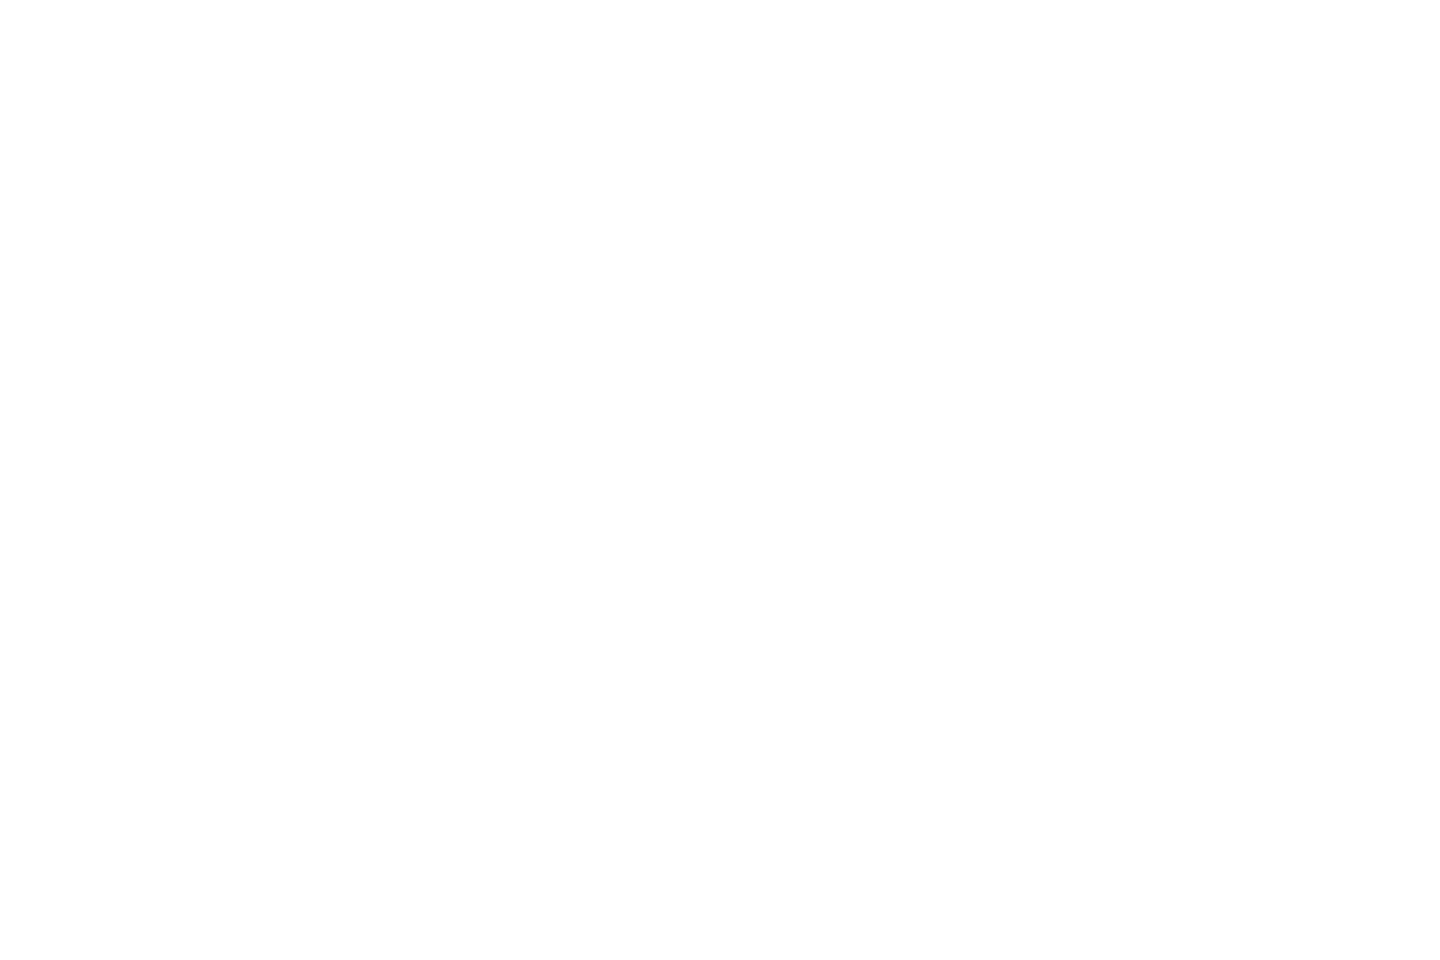

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

middle phase: length= 100


<IPython.core.display.Javascript object>


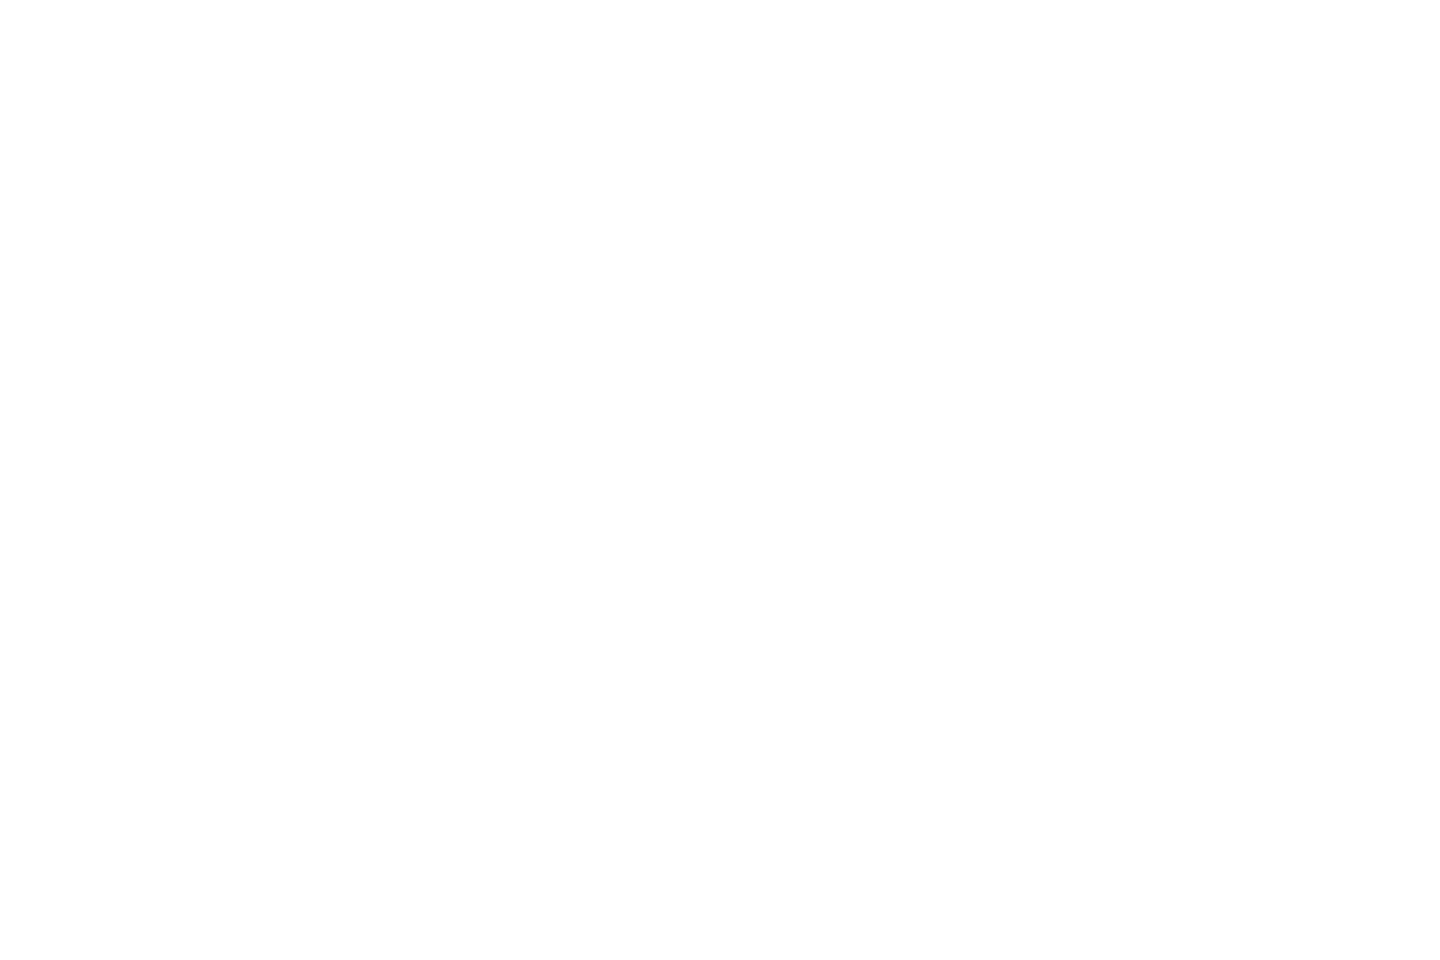

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

final phase: length= 100


<IPython.core.display.Javascript object>


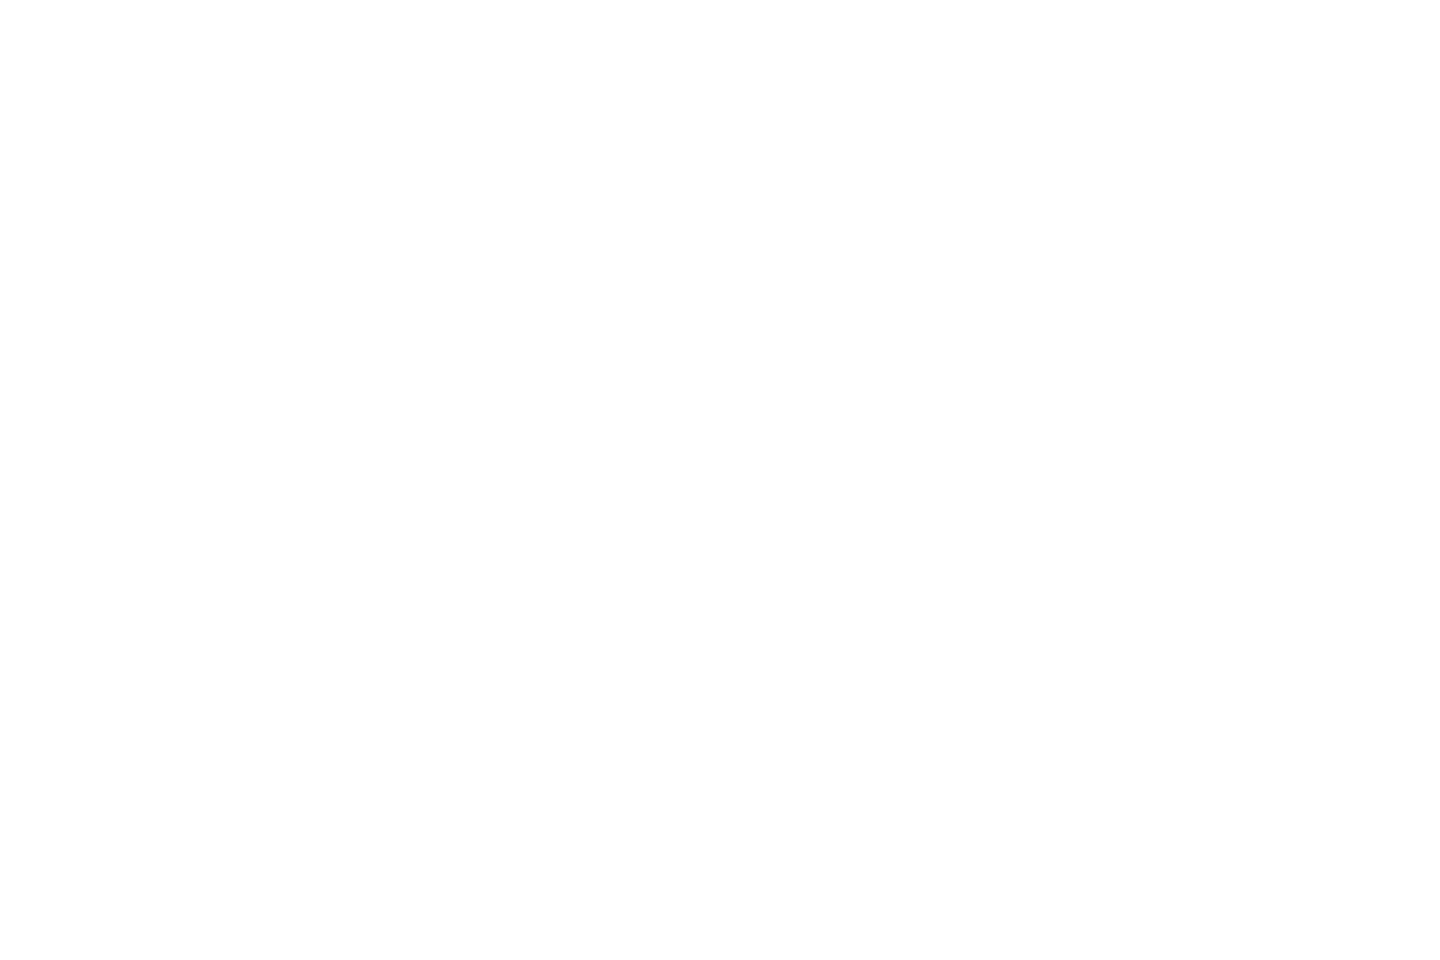

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

<IPython.core.display.Javascript object>


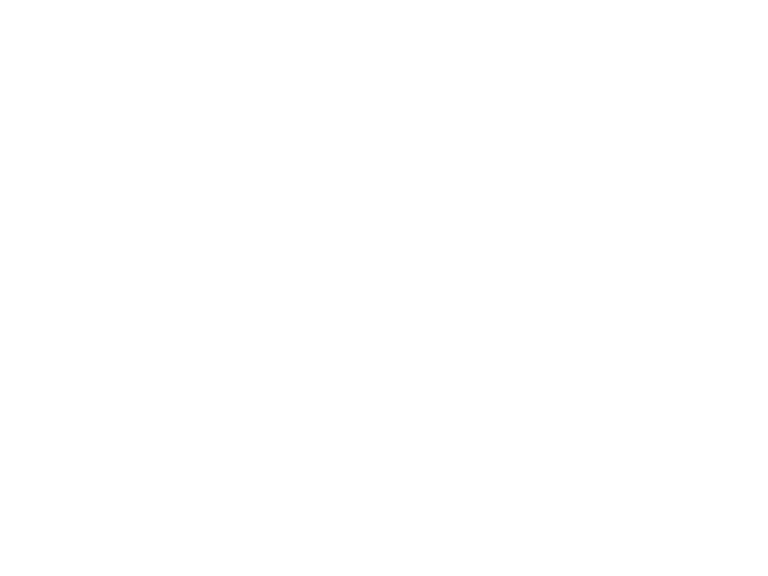

<IPython.core.display.Javascript object>


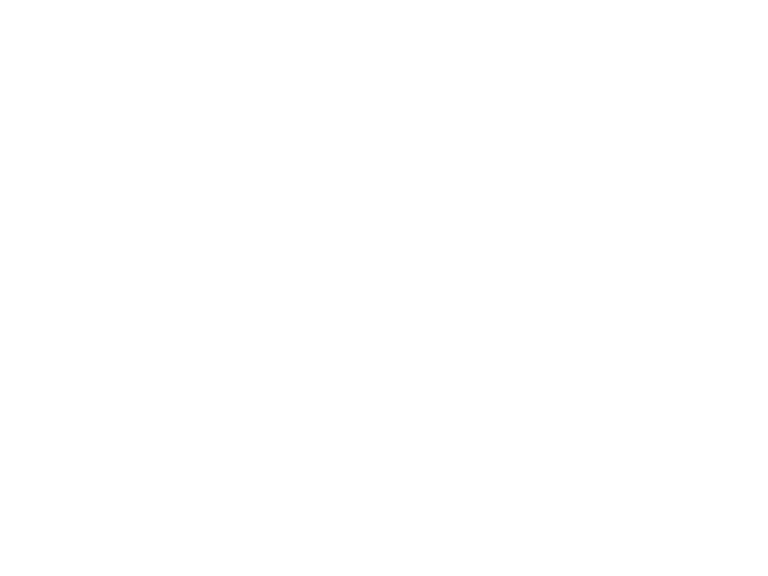

Ground truth of part / whole


In [94]:
# run the spike_recording() to generate figures
import seaborn as sns
color_map = get_color_map(cfg['data'])
sns.set_theme(style='dark')


#draw initial phase
print('initial phase: length=',cfg['len_visual'])
spike_recording(spk1, spk2, label1, label2, start=0, end = cfg['len_visual'],shift=cfg['shift'], name=color_map, GT=False)

#draw middle phase
print('middle phase: length=',cfg['len_visual'])
spike_recording(spk1, spk2, label1, label2, start=cfg['T']//3-cfg['len_visual'], end = cfg['T']//3,shift=cfg['shift'], name=color_map, GT=False)

#draw final phase
print('final phase: length=',cfg['len_visual'])
spike_recording(spk1, spk2, label1, label2, start=cfg['T']-cfg['len_visual'], end = cfg['T'],shift=cfg['shift'], name=color_map, GT=True)
print('Ground truth of part / whole')

In [95]:
# program to generate the animation

% matplotlib notebook
from matplotlib.animation import FuncAnimation
import time
import sys

# figsizes = [(12.0, 1.0), (12.0, 1.5), (12.0, 2.5)]
color_map = 'Green'
sns.set_theme(style='dark')
def animation(ani_record):
    T = len(ani_record)
    W = ani_record[0][0].shape[0]
    H = ani_record[0][0].shape[1]
    # title = [['spk1', 'ref1', 'V1', 'feedback1', 'gamma1', 'CD1', 'gamma1+'], \
    #          ['driv1', '', 'V2-', 'driv2', 'top-down', '', ''], \
    #          ['spk2', 'ref2', 'V2', 'gamma2', '', 'CD2', 'gamma2+']]
    title = [['spk1', 'delta1', 'gamma1', 'to DAE1'], \
             ['x', 'skip', 'D2', 'Gamma'], \
             ['spk2', 'delta2', 'gamma2', 'to DAE2']]

    fig, ax = plt.subplots(nrows=3, ncols=4)

    im = []
    for j in range(len(ax)):
        for i in ax[j]:
            im.append(i.imshow(np.random.rand(W, H),cmap='copper'))

    for i in range(len(ax)):
        for j in range(len(ax[i])):
            axnow = ax[i][j]
            axnow.axis('off')
            axnow.set_title(title[i][j], fontsize=8)

    def animate(t):
        print('\r', end="")
        print('progress: {}%'.format(int(100*t/T)), '#'*int((100*t/T)//2),end='')
        sys.stdout.flush()
        time.sleep(0.05)
        for i in range(len(im)):
            m = im[i]
            m.set_data(ani_record[t][i])
        plt.suptitle('t = ' + str(t) + '/' + str(T), fontsize=5)

    ani = FuncAnimation(fig, animate, blit=True, frames=T, repeat=True,
                        interval=200)
    plt.tight_layout()
    ani.save('./animation.gif', writer='imgemagick', fps=10)
    plt.show()

<IPython.core.display.Javascript object>


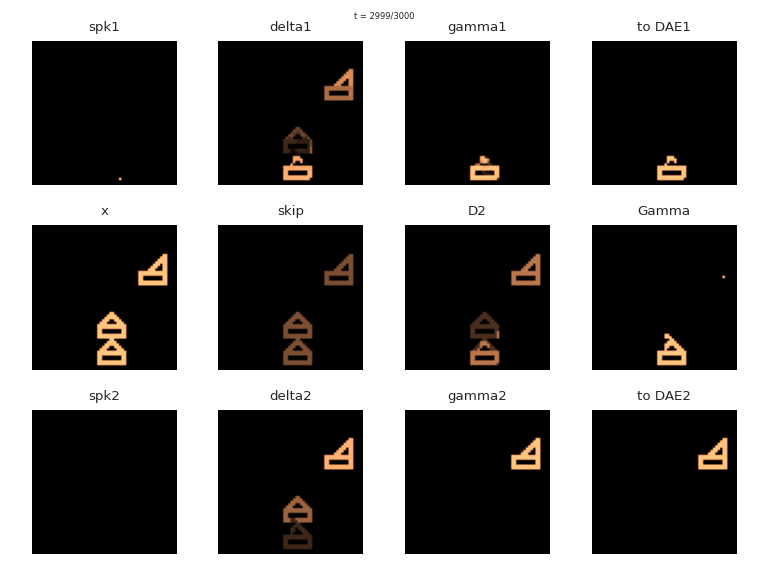

MovieWriter imgemagick unavailable; using Pillow instead.


progress: 99% #################################################

In [96]:
# run the animation, it may taks several minutes.
# the gif is saved as './animation.gif'
# color_map: 'copper'

animation(ani_record)

# spk1: spike firing in part--level visible layer
# spk2: spike firing in whole-level visible layer
# delta1: refractory states of pat--level neurons (more salient color indicate more refractory)
# delta2: refractory states of whole-level neurons (more salient color indicate more refractory)
# gamma1: delayed feedback from DAE1
# gamma2: delayed feedback from DAE2
# to DAE1: integrated spk1 as input fed to DAE1
# to DAE2: integrated spk2 as input fed to DAE2
# x:       input image
# skip: skip connection input to whole level (*lambda2)
# D2: bottom-up input to whole level (*lambda1): D2
# Gamma: inter-level feedback from whole-level to part-level